# 약물 효과 예측 인공지능 모델 실습
프로포폴, 레미펜타닐 투여 후 마취 심도(bispectral index) 예측 모델

## 본 프로그램에서 이용할 라이브러리 설치 및 import

In [ ]:
!pip install vitaldb

import vitaldb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data loading

##VitalDB Web API를 통해 데이터 로딩


In [ ]:
df_trks = pd.read_csv('https://api.vitaldb.net/trks')
df_cases = pd.read_csv("https://api.vitaldb.net/cases")

In [ ]:
# Track DataFrame확인    ## .head(), .tail()도 사용가능.
df_trks

In [ ]:
# Track name 확인
df_trks[df_trks.caseid == 1].tname

## same as..
#df_trks[df_trks['caseid'] == 1]['tname']

In [ ]:
# 전체 목록 확인
df_trks[df_trks.caseid == 1].tname.tolist()

##same as,
#print(df_trks[df_trks.caseid == 1].tname.tolist())

In [ ]:
# Cases DataFrame확인
df_cases

In [ ]:
# Cases DataFrame의 column명들만 추출해서 확인
df_cases.columns

In [ ]:
# female은 1으로, male 은 0으로 치환
df_cases['sex'] = (df_cases['sex'] == 'F').astype(int)  

##Case ID 선택 (inclusion, exclusion criteria)
- 2시간 이상
- 전신 마취
- 18세 이상
- PPF20_VOL, RFTN20_VOL, PPF20_CE, RFTN20_CE, BIS 트랙이 존재
- 몸무게 35 kg 이상

In [ ]:
caseids = list(
  set(df_trks.loc[df_trks['tname'] == 'Orchestra/PPF20_VOL', 'caseid']) & ## loc를 사용하는게 아래보다 빠름.
  set(df_trks[df_trks['tname'] == 'Orchestra/RFTN20_VOL']['caseid']) &
  set(df_trks[df_trks['tname'] == 'Orchestra/PPF20_CE']['caseid']) &
  set(df_trks[df_trks['tname'] == 'Orchestra/RFTN20_CE']['caseid']) &
  set(df_trks[df_trks['tname'] == 'BIS/BIS']['caseid']) & 
  set(df_cases[df_cases['age'] > 18]['caseid']) & 
  set(df_cases[df_cases['weight'] > 35]['caseid']) &
  set(df_cases[df_cases['caseend'] > 7200]['caseid']) &   ## 2시간 이상의 수술.
  set(df_cases[df_cases['ane_type'] == 'General']['caseid'])  ## 전신 마취
  )
np.random.shuffle(caseids)

In [ ]:
print(f'Included cases numeber: {len(caseids)}')

# 데이터 전처리


## 하나의 Caseid로 먼저 실습 

In [ ]:
caseid = 5180 #5180

In [ ]:
# 20초 간격으로 Propofol 및 BIS 데이터 추출
tracknames = ['Orchestra/PPF20_VOL', 'BIS/BIS']
vals = vitaldb.load_case(caseid, tracknames, 20)

print(vals.shape) # Matrix shape 확인
print()
print(vals[:10]) # 데이터 일부 확인

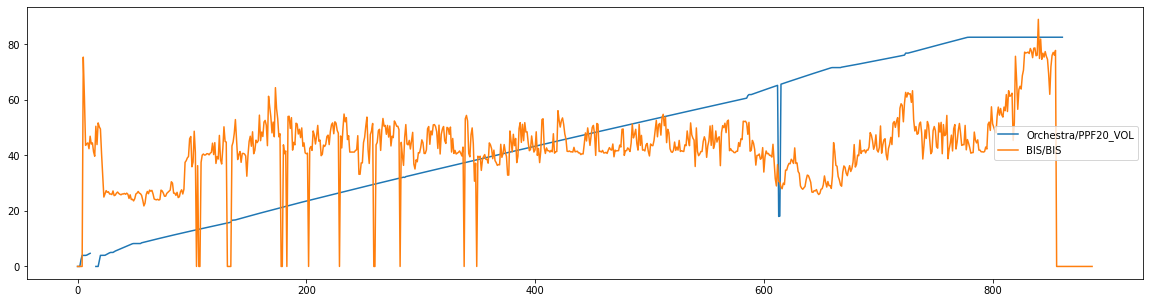

In [ ]:
# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
for idx, trk in enumerate(tracknames):
  plt.plot(vals[:,idx],label=trk)
plt.legend(loc='center right')
plt.show()

In [ ]:
# 결측치 확인
print(np.isnan(vals).sum(axis=0)) # track
print()
np.where(np.isnan(vals).sum(axis=1) > 0)[0] #time

In [ ]:
# track - time별 결측치 확인
for idx, trk in enumerate(tracknames):
  print(f' Missing values of {trk} track at : {np.where(np.isnan(vals[:, idx]))[0]}')
  print()

In [ ]:
#  결측치 처리 방법1 - 전후 값으로 치환
vals_ = vals[10:20]
print("#"*4, "Original", "#"*4)
print(vals_)
print()
print("#"*4, "Forward filling", "#"*4)
print(pd.DataFrame(vals_).fillna(method='ffill').values)
print()
print("#"*4, "Backward filling", "#"*4)
print(pd.DataFrame(vals_).fillna(method='bfill').values)
print()
#  결측치 처리 방법2 - 전후 값으로 치환
print("#"*4, "Interpolation", "#"*4) 
print(pd.DataFrame(vals_).interpolate().values)


In [ ]:
#  결측치 처리 방법3 - 특정값으로 치환
print(np.nan_to_num(vals_, 0))

## 전체 실행 (TODO)
- dataset을 담을 변수를 설정
- propofol(ppf20), remifentanil(rftn20), bis를 로딩한다
- 기록된 데이터가 짧거나, drug infusion이 실제 없었던 케이스, bis값이 적절하지 않은 케이스는 거르기
- 결측값 및 음수 처리

In [ ]:
######### TODO 1 #########

# vital 파일로부터 dataset 을 만듬
x_ppf_dose = []  # 각 레코드의 프로포폴 주입량
x_rft_dose = []  # 각 레코드의 레미펜타닐 주입량
x_aswh = []  # 각 레코드의 나이, 성별, 키, 몸무게
x_caseid = []  # 각 레코드의 caseid
y = []  # 각 레코드의 출력값 (bis)
y_old = []  # 고전적 모델의 예측값

LSTM_TIMEPOINTS = 180
MAX_CASES = 50  # 본 예제에서 사용할 최대 case 수

# 데이터 로딩했을 때 컬럼 순서
PPF_DOSE = 0
RFT_DOSE = 1
PPF_CE = 2
RFT_CE = 3
BIS = 4

icase = 0  # 현재 로딩 중인 케이스 번호
ncase = min(MAX_CASES, len(caseids))
for caseid in caseids:  # 본 연구에 사용할 각 case에 대하여
    print('loading {} ({}/{})'.format(caseid, icase, ncase), end='...', flush=True)

    ######### TODO 1 : Step 1 #########
    # 10초 간격으로, propofol volume, remifentanil volume, propofol CE, remifentanil CE, BIS 데이터 추출
    vals = #### INSERT CODE ####

    ######### TODO 1 : Step 2 #########
    # 결측값은 측정된 마지막 값으로 대체
    vals = #### INSERT CODE ####

    ######### TODO 1 : Step 3 #########
    # 마지막 남은 맨 앞 쪽 결측값은 0으로 대체
    vals = #### INSERT CODE ####

    # drug 주입을 하지 않은 case 혹은 bis를 사용하지 않은 case는 제외
    if (np.max(vals, axis=0) <= 1).any():
        print('no drug infusion or bis')
        continue

    # drug infusion 시작 시간을 구하고 그 이전을 삭제
    first_ppf_idx = np.where(vals[:, PPF_DOSE] > 1)[0][0]
    first_rft_idx = np.where(vals[:, RFT_DOSE] > 1)[0][0]
    first_drug_idx = min(first_ppf_idx, first_rft_idx)
    vals = vals[first_drug_idx:, :]

    # volume 을 rate로 변경
    vals[1:, PPF_DOSE] -= vals[:-1, PPF_DOSE]
    vals[1:, RFT_DOSE] -= vals[:-1, RFT_DOSE]
    vals[0, PPF_DOSE] = 0
    vals[0, RFT_DOSE] = 0

    ######### TODO 1 : Step 4 #########
    # 음수 값을 0으로 대체
    vals[#### INSERT CODE #### ] = 0

    # bis 값의 첫 값이 80 이하이거나 마지막 값이 70 이하인 case는 사용하지 않음
    valid_bis_idx = np.where(vals[:, BIS] > 0)[0]
    first_bis_idx = valid_bis_idx[0]
    last_bis_idx = valid_bis_idx[-1]
    if vals[first_bis_idx, BIS] < 80:
        print('first bis < 80')
        continue
    if vals[last_bis_idx, BIS] < 70:
        print('last bis < 70')
        continue

    # infusion 시작 전 LSTM_TIMEPOINTS 동안의 dose와 bis를 모두 0으로 세팅
    vals = np.vstack((np.zeros((LSTM_TIMEPOINTS - 1, vals.shape[1])), vals))

    ######### TODO 1 : Step 5 #########
    # 현 case의 나이, 성별, 키, 몸무게를 가져옴
    aswh = #### INSERT CODE ####
    aswh = aswh.values.astype(float).flatten()

    # case 시작 부터 종료까지 dataset 에 넣음
    for irow in range(1, vals.shape[0] - LSTM_TIMEPOINTS - 1):
        bis = vals[irow + LSTM_TIMEPOINTS, BIS]
        if bis == 0:
            continue

        # 데이터셋에 입력값을 넣음
        x_ppf_dose.append(vals[irow:irow + LSTM_TIMEPOINTS, PPF_DOSE])
        x_rft_dose.append(vals[irow:irow + LSTM_TIMEPOINTS, RFT_DOSE])

        x_aswh.append(aswh)
        x_caseid.append(caseid)
        y.append(bis / 100)

        ppf_ce = vals[irow + LSTM_TIMEPOINTS, PPF_CE]
        rft_ce = vals[irow + LSTM_TIMEPOINTS, RFT_CE]
         
        ug = (ppf_ce / 4.47 + rft_ce / 19.3)**1.43
        y_old.append(0.98 - 0.98 * (ug / (1 + ug)))


    # 사용할 case
    print('done')
    icase += 1
    if icase >= ncase:
        break


## 데이터셋 포맷 및 차원 변환

In [ ]:
# 입력 데이터셋을 numpy array로 변경
x_ppf_dose = np.array(x_ppf_dose)[..., None]  # LSTM 에 넣기 위해서는 3차원이어야 한다. 마지막 차원을 추가
x_rft_dose = np.array(x_rft_dose)[..., None]
x_aswh = np.array(x_aswh)
y = np.array(y)
y_old = np.array(y_old)
x_caseid = np.array(x_caseid)

# 최종적으로 로딩 된 caseid
caseids = np.unique(x_caseid)

# normalize data
x_aswh = (x_aswh - np.mean(x_aswh, axis=0)) / np.std(x_aswh, axis=0)


## 데이터를 학습(train)과 테스트(test)로 나누기

In [ ]:
# train, test case로 나눔
ntest = int(ncase * 0.1)
ntrain = ncase - ntest
train_caseids = caseids[:ntrain]
test_caseids = caseids[ntrain:ncase]

# train set과 test set 으로 나눔
train_mask = np.array([caseid in train_caseids for caseid in x_caseid])
test_mask = np.array([caseid in test_caseids for caseid in x_caseid])
x_train = [x_ppf_dose[train_mask], x_rft_dose[train_mask], x_aswh[train_mask]]
y_train = y[train_mask]
x_test = [x_ppf_dose[test_mask], x_rft_dose[test_mask], x_aswh[test_mask]]
y_test = y[test_mask]
y_old = y_old[test_mask]

print('train: {} cases {} samples, testing: {} cases {} samples'.format(len(train_caseids), np.sum(train_mask), len(test_caseids), np.sum(test_mask)))

# Model building


In [ ]:
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, LSTM, Input, concatenate
from keras.callbacks import EarlyStopping
import tensorflow as tf

# 모델 설계

def build_model(LSTM_NODES, FNN_NODES, DROP_RATE):
    
    input_cov = Input(batch_shape=(None, 4))
    input_ppf = Input(batch_shape=(None, LSTM_TIMEPOINTS, 1))
    input_rft = Input(batch_shape=(None, LSTM_TIMEPOINTS, 1))
    output_ppf = LSTM(LSTM_NODES, input_shape=(LSTM_TIMEPOINTS, 1), activation='tanh')(input_ppf)
    output_rft = LSTM(LSTM_NODES, input_shape=(LSTM_TIMEPOINTS, 1), activation='tanh')(input_rft)
    output = concatenate([output_ppf, output_rft, input_cov])
    output = Dense(FNN_NODES)(output)
    output = Dropout(DROP_RATE)(output)
    output = Dense(1, activation='sigmoid')(output)
    model = Model(inputs=[input_ppf, input_rft, input_cov], outputs=[output])
    
    return model


In [ ]:
# 모델 생성 및 구조 확인
model = build_model(32, 32, 0.5)
model.summary()

In [ ]:
mse = tf.keras.losses.MeanSquaredError()

model.compile(loss=mse, optimizer='sgd', metrics=[mse])
hist = model.fit(x_train, y_train,
                 batch_size=64,
                 validation_split=0.2, 
                 epochs=1, 
                 callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')])

# 결과 출력

In [ ]:
# 예측
y_pred = model.predict(x_test).flatten()
print(f"Test MAPE (LSTM): {mape(y_test, y_pred):.1f}%")
print(f"Test MAPE (Short): {mape(y_old, y_pred):.1f}%")
print()

# 각 case에서 예측 결과를 그림으로 확인
import matplotlib.pyplot as plt
for caseid in test_caseids:
    case_mask = (x_caseid[test_mask] == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    print('CaseID {}, LSTM MAPE={}, Short MAPE={}'.format(caseid, 
      mape(y_test[case_mask], y_pred[case_mask]), 
      mape(y_test[case_mask], y_old[case_mask])
      ))

    t = np.arange(0, case_len)
    plt.figure(figsize=(20, 5))
    plt.plot(t, y_test[case_mask], label='BIS')  # 측정 결과
    plt.plot(t, y_pred[case_mask], label='LSTM')  # LSTM model
    plt.plot(t, y_old[case_mask], label='Short')  # Short model
    plt.legend()
    plt.xlim([0, case_len])
    plt.ylim([0, 1])
    plt.show()

# 모델 학습 및 추론 (TODO)

In [ ]:
######### TODO 2 #########
# 모델 설계 및 학습

######### TODO 2 : Step 1 #########
# LSTM의 node 수 8, FNN의 node 수 16, dropout rate는 0.2인 모델을 만들어주세요.
model = #### INSERT CODE ####

######### TODO 2 : Step 2 #########
# 손실함수는 mean absolute error, 옵티마이저는 Adam, 평가방법은 mean absolute percentage error로 모델을 컴파일 해주세요.
mae = #### INSERT CODE ####
mape = #### INSERT CODE ####

model.compile(#### INSERT CODE ####)

######### TODO 2 : Step 3 #########
# 모델 검증을 위해 10%로 split해서 미니배치 크기는 256으로 모델을 epoch은 10회로 학습해주세요.
hist = model.fit(x_train, y_train,
                 #### INSERT CODE ####
                 )


In [ ]:
# 예측
y_pred = model.predict(x_test).flatten()
print(f"Test MAPE (LSTM): {mape(y_test, y_pred):.1f}%")
print(f"Test MAPE (Short): {mape(y_old, y_pred):.1f}%")
print()

# 각 case에서 예측 결과를 그림으로 확인
import matplotlib.pyplot as plt
for caseid in test_caseids:
    case_mask = (x_caseid[test_mask] == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    print('CaseID {}, LSTM MAPE={}, Short MAPE={}'.format(caseid, 
      mape(y_test[case_mask], y_pred[case_mask]), 
      mape(y_test[case_mask], y_old[case_mask])
      ))

    t = np.arange(0, case_len)
    plt.figure(figsize=(20, 5))
    plt.plot(t, y_test[case_mask], label='BIS')  # 측정 결과
    plt.plot(t, y_pred[case_mask], label='LSTM')  # LSTM model
    plt.plot(t, y_old[case_mask], label='Short')  # Short model
    plt.legend()
    plt.xlim([0, case_len])
    plt.ylim([0, 1])
    plt.show()